In [ ]:
# ! pip install --user pydl
# use DESI env 19.2 instead 

In [2]:
import os
import time 
import h5py 
import numpy as np 
from astropy.io import fits 
from pydl.pydlutils.spheregroup import spherematch
# plotting 
#import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline


#! module load latex for this 
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['axes.linewidth'] = 1.5
#mpl.rcParams['axes.xmargin'] = 1
#mpl.rcParams['xtick.labelsize'] = 'x-large'
#mpl.rcParams['xtick.major.size'] = 5
#mpl.rcParams['xtick.major.width'] = 1.5
#mpl.rcParams['ytick.labelsize'] = 'x-large'
#mpl.rcParams['ytick.major.size'] = 5
#mpl.rcParams['ytick.major.width'] = 1.5
#mpl.rcParams['legend.frameon'] = False



### ANALISIS OF OVERLAP FOR DR8c

In [12]:
#no need to rerun this go below
f_decals = fits.open(os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8c/decam/sweep', 
                'sweep-130p030-140p035.fits')) 
decals = f_decals[1].data 
print('%i decals objects' % len(decals['ra']))
    
# read in prime sweep
f_prime = fits.open(os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8c/90prime-mosaic/sweep', 
                'sweep-130p030-140p035.fits'))
prime = f_prime[1].data 
print('%i prime objects' % len(prime['ra']))

1453957 decals objects
1279712 prime objects


In [13]:
# no need to rerun this go below
decals_radec_cut = (decals['ra'] > 136.) & (decals['ra'] < 137.) & (decals['dec'] > 32.)  & (decals['dec'] < 33.) 
prime_radec_cut = (prime['ra'] > 136.) & (prime['ra'] < 137.) & (prime['dec'] > 32.)  & (prime['dec'] < 33.) 
print('%i decals objects within cut' % np.sum(decals_radec_cut))
print('%i prime objects within cut' % np.sum(prime_radec_cut)) 

54320 decals objects within cut
46991 prime objects within cut


(31.8, 33.2)

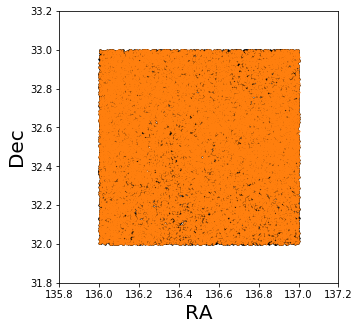

In [14]:
# no need to rerun this, go below
# validate the scatter plots 
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], c='k', s=2) 
sub.scatter(prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], c='C1', s=1) 
sub.set_xlabel('RA', fontsize=20) 
sub.set_xlim(135.8, 137.2) 
sub.set_ylabel('Dec', fontsize=20) 
sub.set_ylim(31.8, 33.2) 

In [15]:
# match no need to redo
t0 = time.time() 
# now lets spherematch 
m_decals, m_prime, d_match = spherematch(
    decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], 
    prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], 
    0.0005, # match lenght roughly 1.5 arcsec
    maxmatch=1) 
print('spehrematch takes', time.time() - t0) 
print('%i out of %i decals objects have match' % (len(m_decals), np.sum(decals_radec_cut)))
print('%i out of %i prime objects have match' % (len(m_prime), np.sum(prime_radec_cut)))
pathdir = '/global/project/projectdirs/desi/users/manera/'
np.save(pathdir+'decals_match-dr8c.npy', m_decals)
np.save(pathdir+'prime_match-dr8c.npy', m_prime)

spehrematch takes 640.1624927520752
42233 out of 54320 decals objects have match
42233 out of 46991 prime objects have match


In [18]:
pathdir = '/global/project/projectdirs/desi/users/manera/'
filename = pathdir + 'decals_match-dr8c.npy'
m_decals = np.load(filename)
filename = pathdir + 'prime_match-dr8c.npy'
m_prime = np.load(filename)

In [19]:
# decals.names gives the list of fields in decals 
# remove from the decals list the fields that are strings 

listdecals = np.ones(len(decals.names))
for i in range(len(decals.names)):
    a = type(decals[decals.names[i]][1])
    if( a == type(str()) ): listdecals[i]=0    

listprime = np.ones(len(prime.names))
for i in range(len(prime.names)):
    a = type(prime[prime.names[i]][1])
    if( a == type(str()) ): listprime[i]=0    

In [21]:
f.close()

In [22]:
# save joint dataset
pathdir = '/global/project/projectdirs/desi/users/manera/'
f = h5py.File(pathdir+'decals_prime.radeccut_dr8c.hdf5', 'w') 
# save all non string decals columns
grp = f.create_group('decals') 
for i, k in enumerate(decals.names): 
    if( listdecals[i] ) :
        if len(decals[k]) == len(decals['ra']):  
            grp.create_dataset(str(k), data=decals[k][decals_radec_cut][m_decals]) 
    else:
         if len(decals[k]) == len(decals['ra']):
            aux = decals[k][decals_radec_cut][m_decals]
            asciiList = [n.encode("ascii", "ignore") for n in aux]
            grp.create_dataset(str(k),  data=asciiList, dtype='S4',) 
            #grp.create_dataset(str(k), (len(asciiList),1), dtype='S4', data=asciiList) 
        
# save all non string prime columns
grp = f.create_group('prime') 
for i, k in enumerate(prime.names):
    if (listprime[i]):
        if len(prime[k]) == len(prime['ra']):  
            grp.create_dataset(str(k), data=prime[k][prime_radec_cut][m_prime]) 
    else:
        if len(decals[k]) == len(decals['ra']):
            aux = prime[k][prime_radec_cut][m_prime]
            asciiList = [n.encode("ascii", "ignore") for n in aux]
            grp.create_dataset(str(k),  data=asciiList, dtype='S4',) 
            #grp.create_dataset(str(k), (len(asciiList),1), dtype='S4', data=asciiList) 
f.close() 

### PLOTS 

In [23]:
# when read decals and prime will overwrite the previous objects, that's fine
pathdir = '/global/project/projectdirs/desi/users/manera/'
f = h5py.File(pathdir+'decals_prime.radeccut_dr8c.hdf5', 'r') 
h5decals = f['decals'] 
h5prime = f['prime'] 

In [24]:
def flux2mag(flux, band='g', method='log'):
    ''' given flux calculate SDSS asinh magnitude
    '''
    if method == 'asinh':
        if band == 'u': b = 1.4e-10
        elif band == 'g': b = 0.9e-10
        elif band == 'r': b = 1.2e-10
        elif band == 'i': b = 1.8e-10
        elif band == 'z': b = 7.4e-10
        else: raise ValueError

        return -2.5/np.log(10) * (np.arcsinh(1.e-9*flux/(2.*b)) + np.log(b))
    elif method == 'log':
        return 22.5 - 2.5 * np.log10(flux)

### R-BAND

In [ ]:
def keys(f):
    return [key for key in f.keys()]
keys(h5decals)    #h5decals.keys() shows view, it can't be sliced like a list thus the function

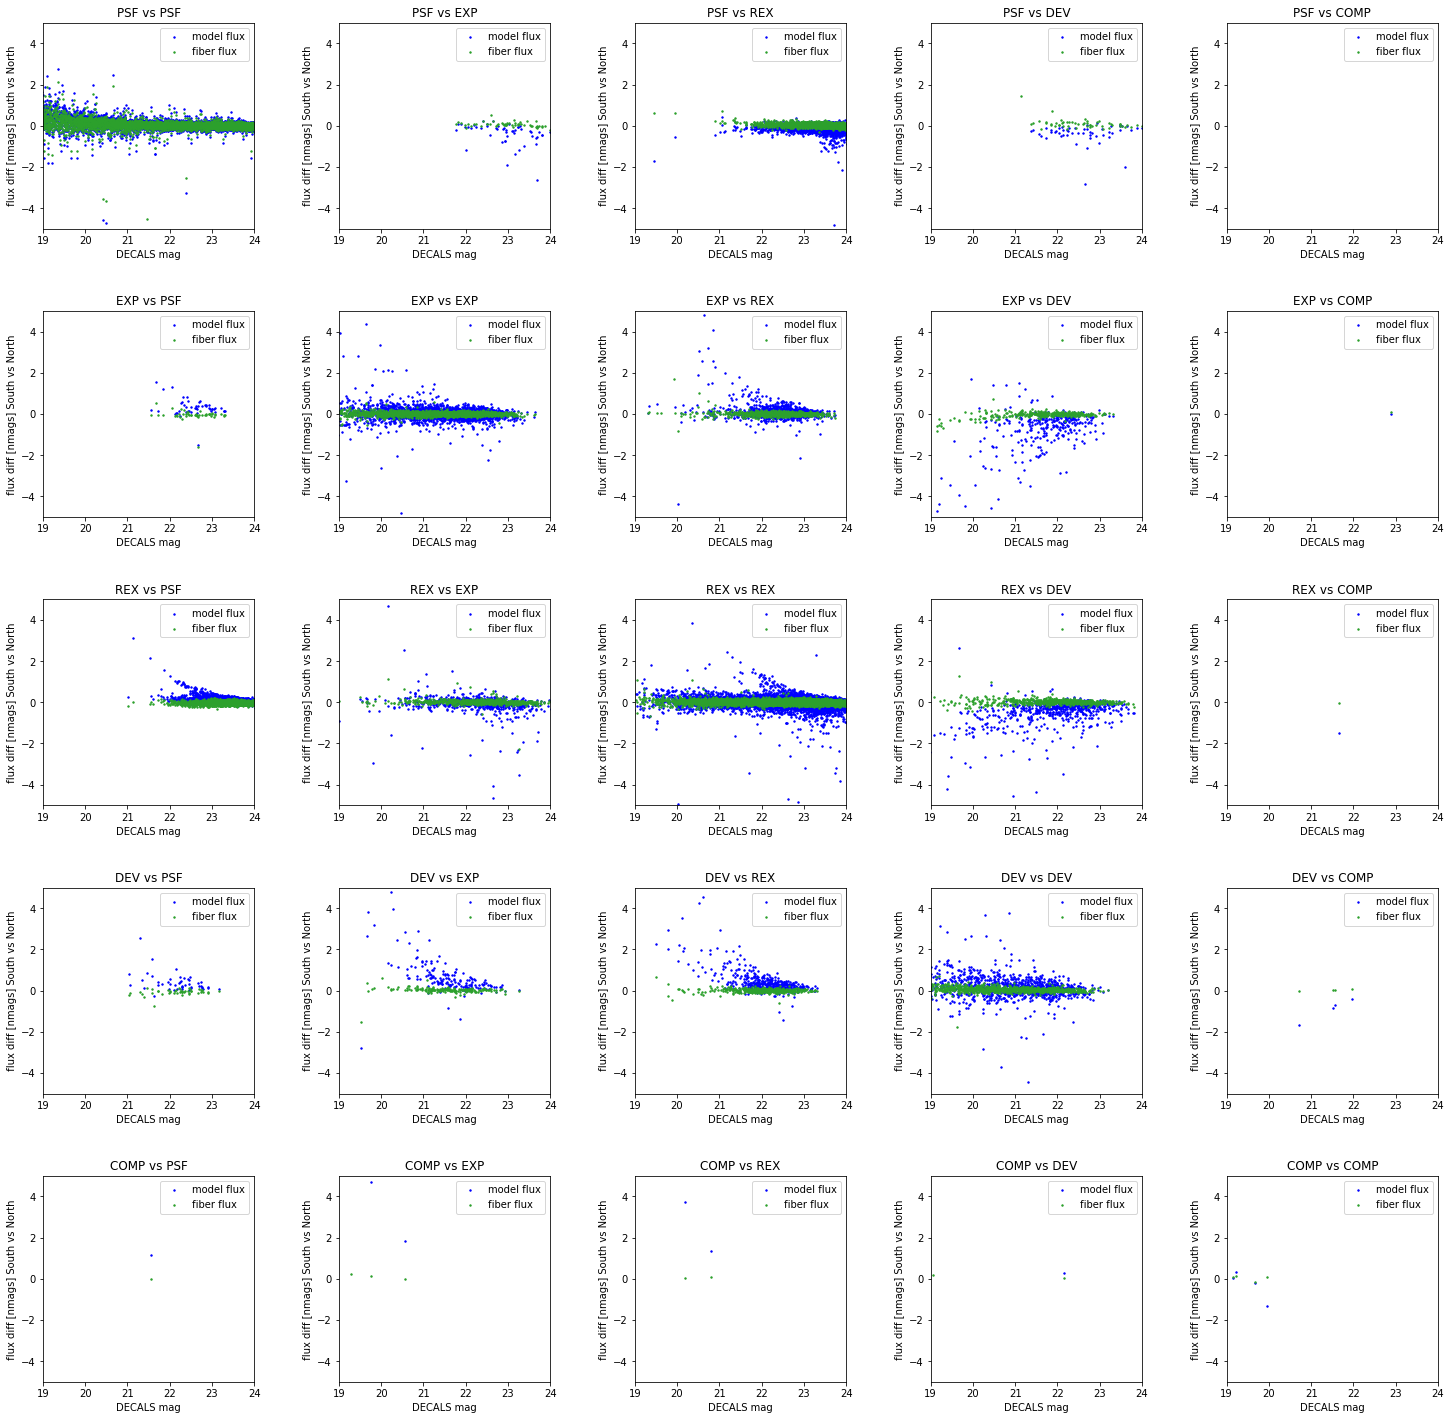

In [42]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_R'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_R'])
          
    decals_std_rflux = np.array(h5decals['FLUX_R'])
    prime_std_rflux = np.array(h5prime['FLUX_R'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1-rband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


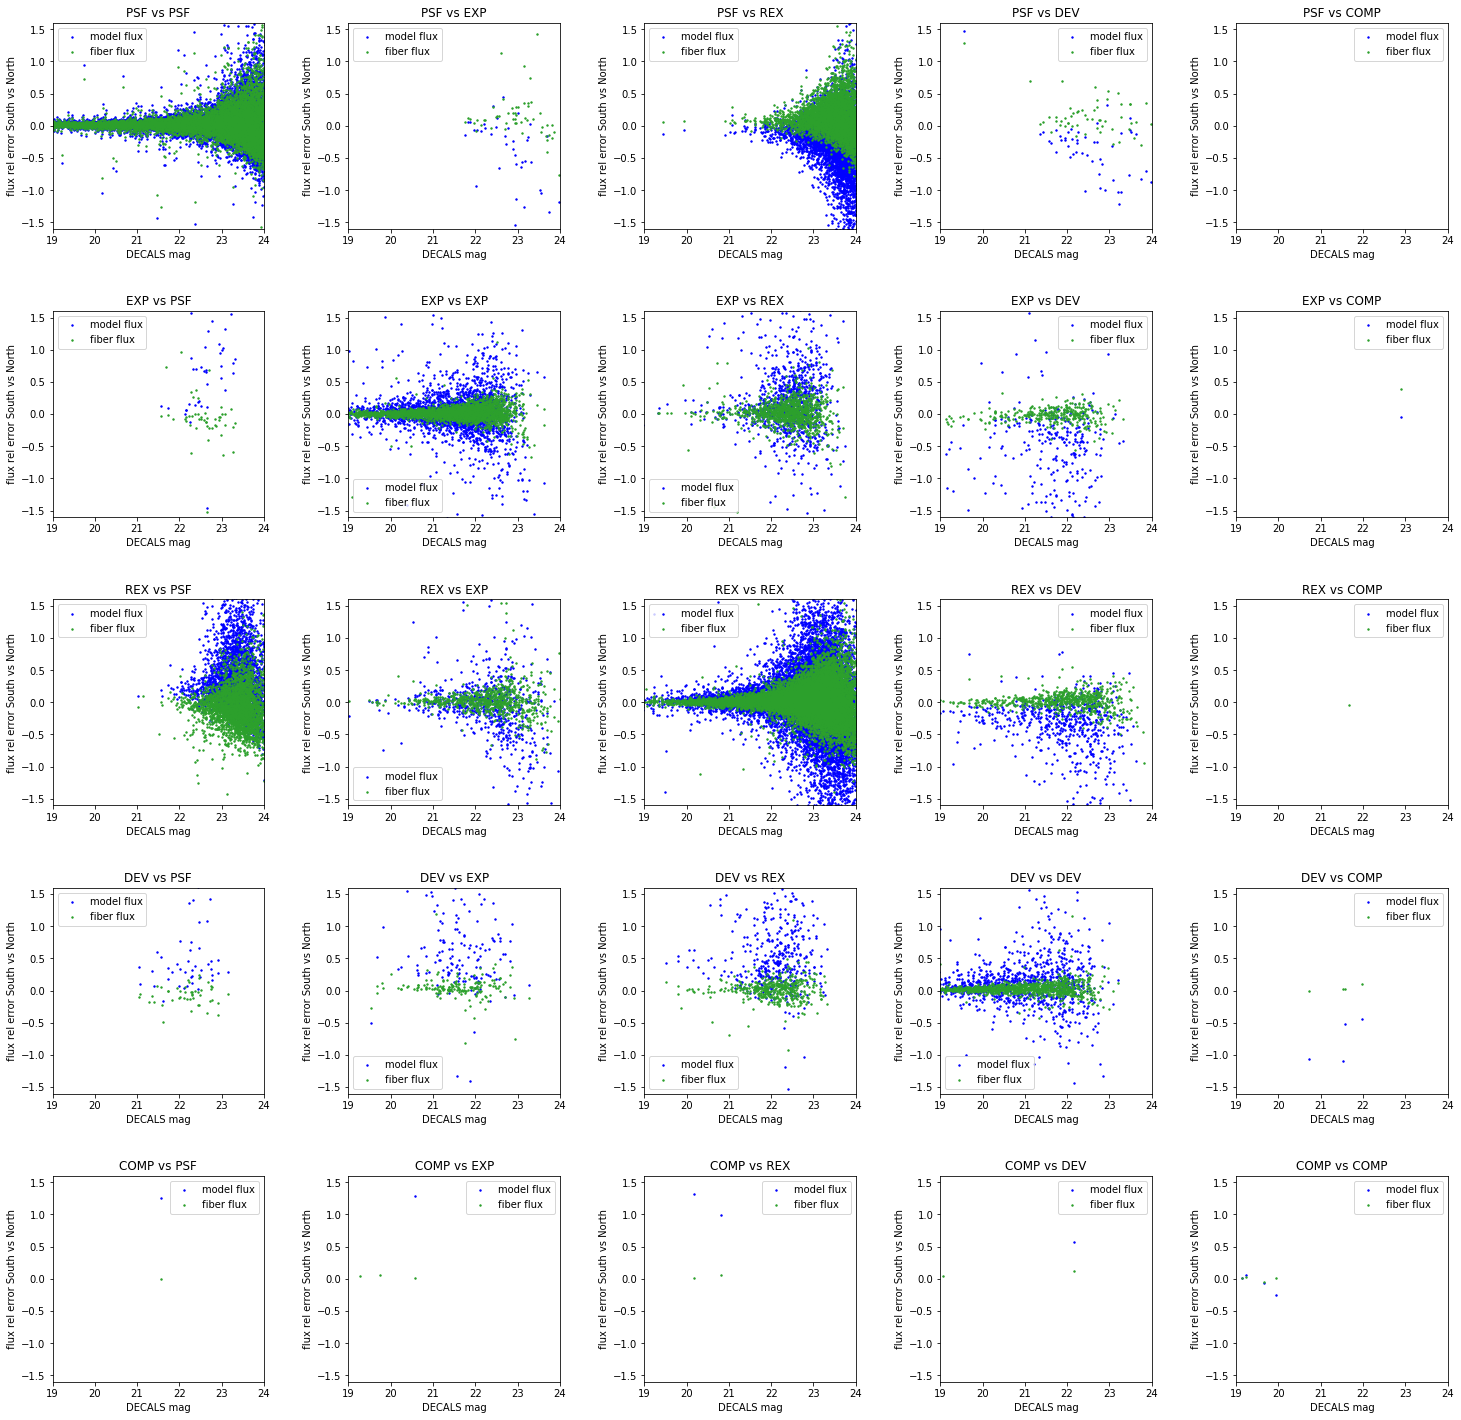

In [53]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_R'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_R'])
          
    decals_std_rflux = np.array(h5decals['FLUX_R'])
    prime_std_rflux = np.array(h5prime['FLUX_R'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2-rband.png")
    plt.show()

### G-BAND

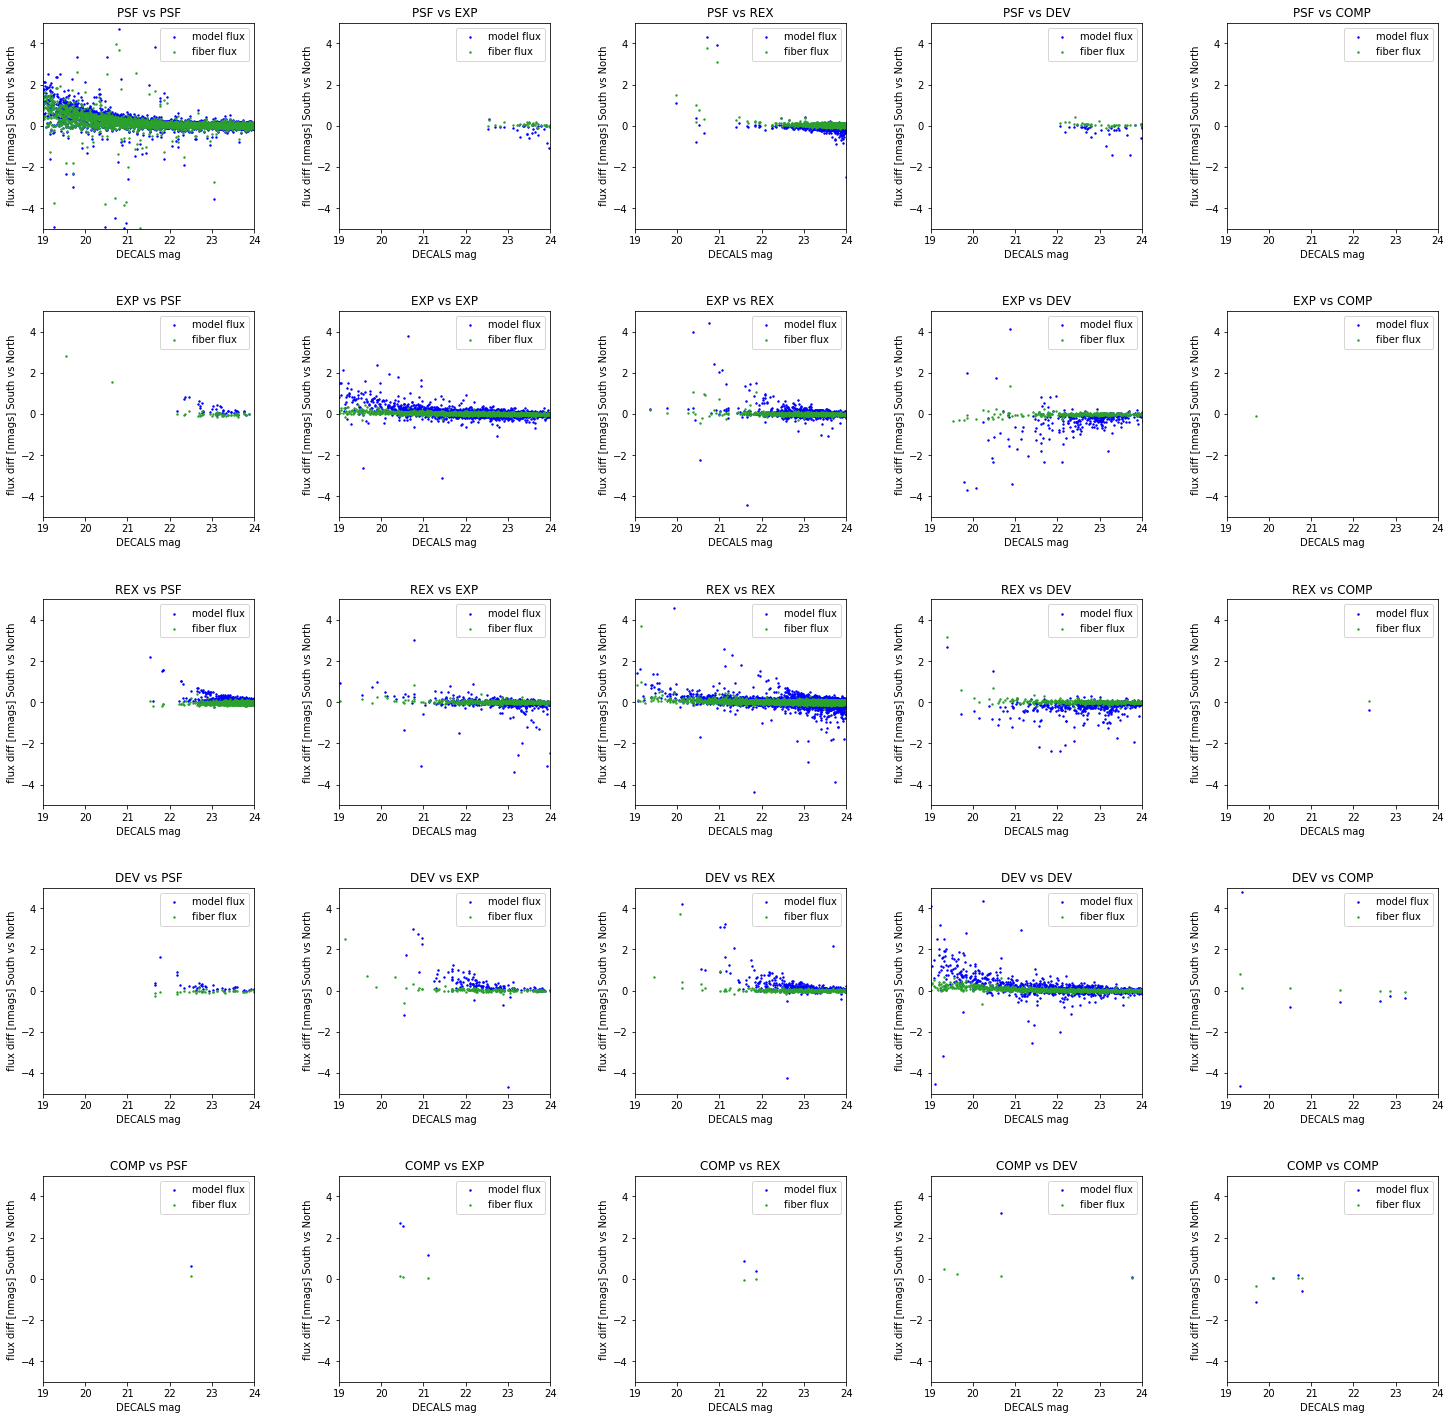

In [41]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_G'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_G'])
          
    decals_std_rflux = np.array(h5decals['FLUX_G'])
    prime_std_rflux = np.array(h5prime['FLUX_G'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1-gband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


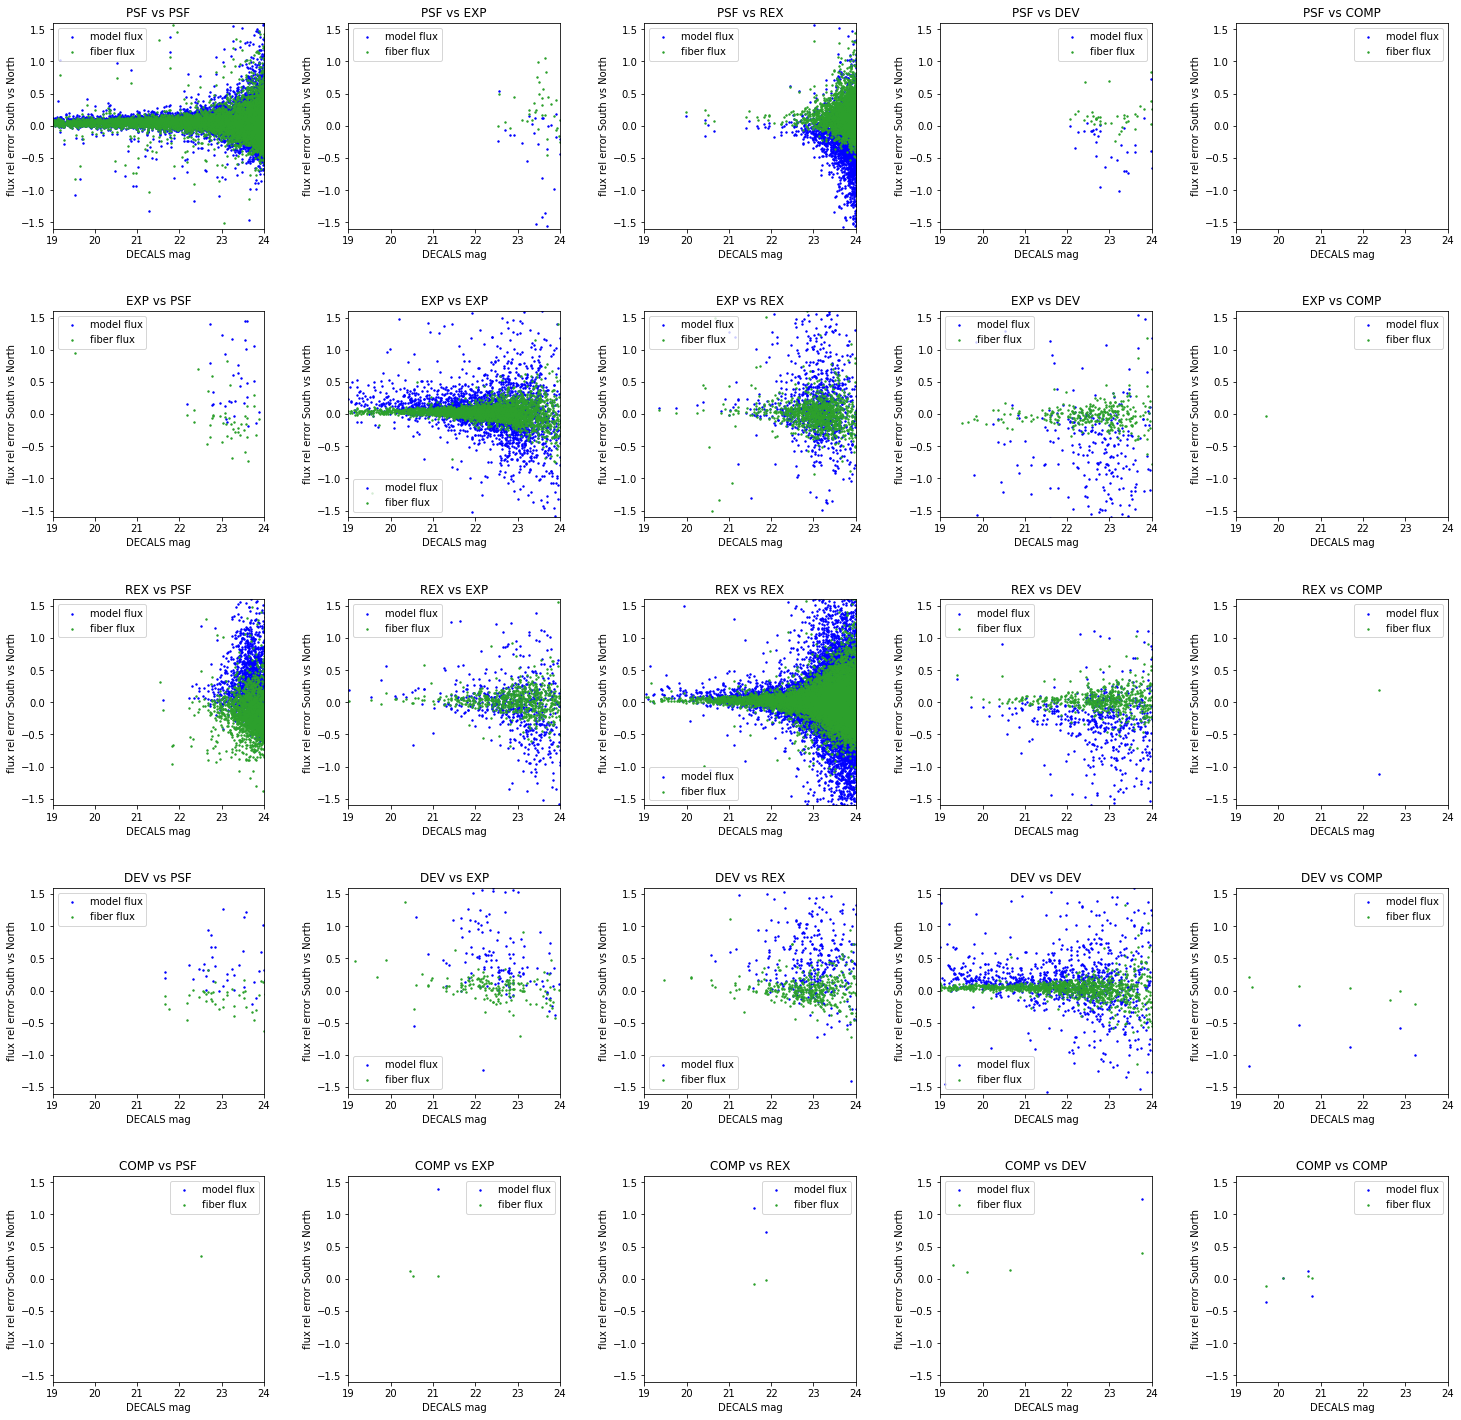

In [56]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_G'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_G'])
          
    decals_std_rflux = np.array(h5decals['FLUX_G'])
    prime_std_rflux = np.array(h5prime['FLUX_G'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2-gband.png")
    plt.show()

### Z-BAND

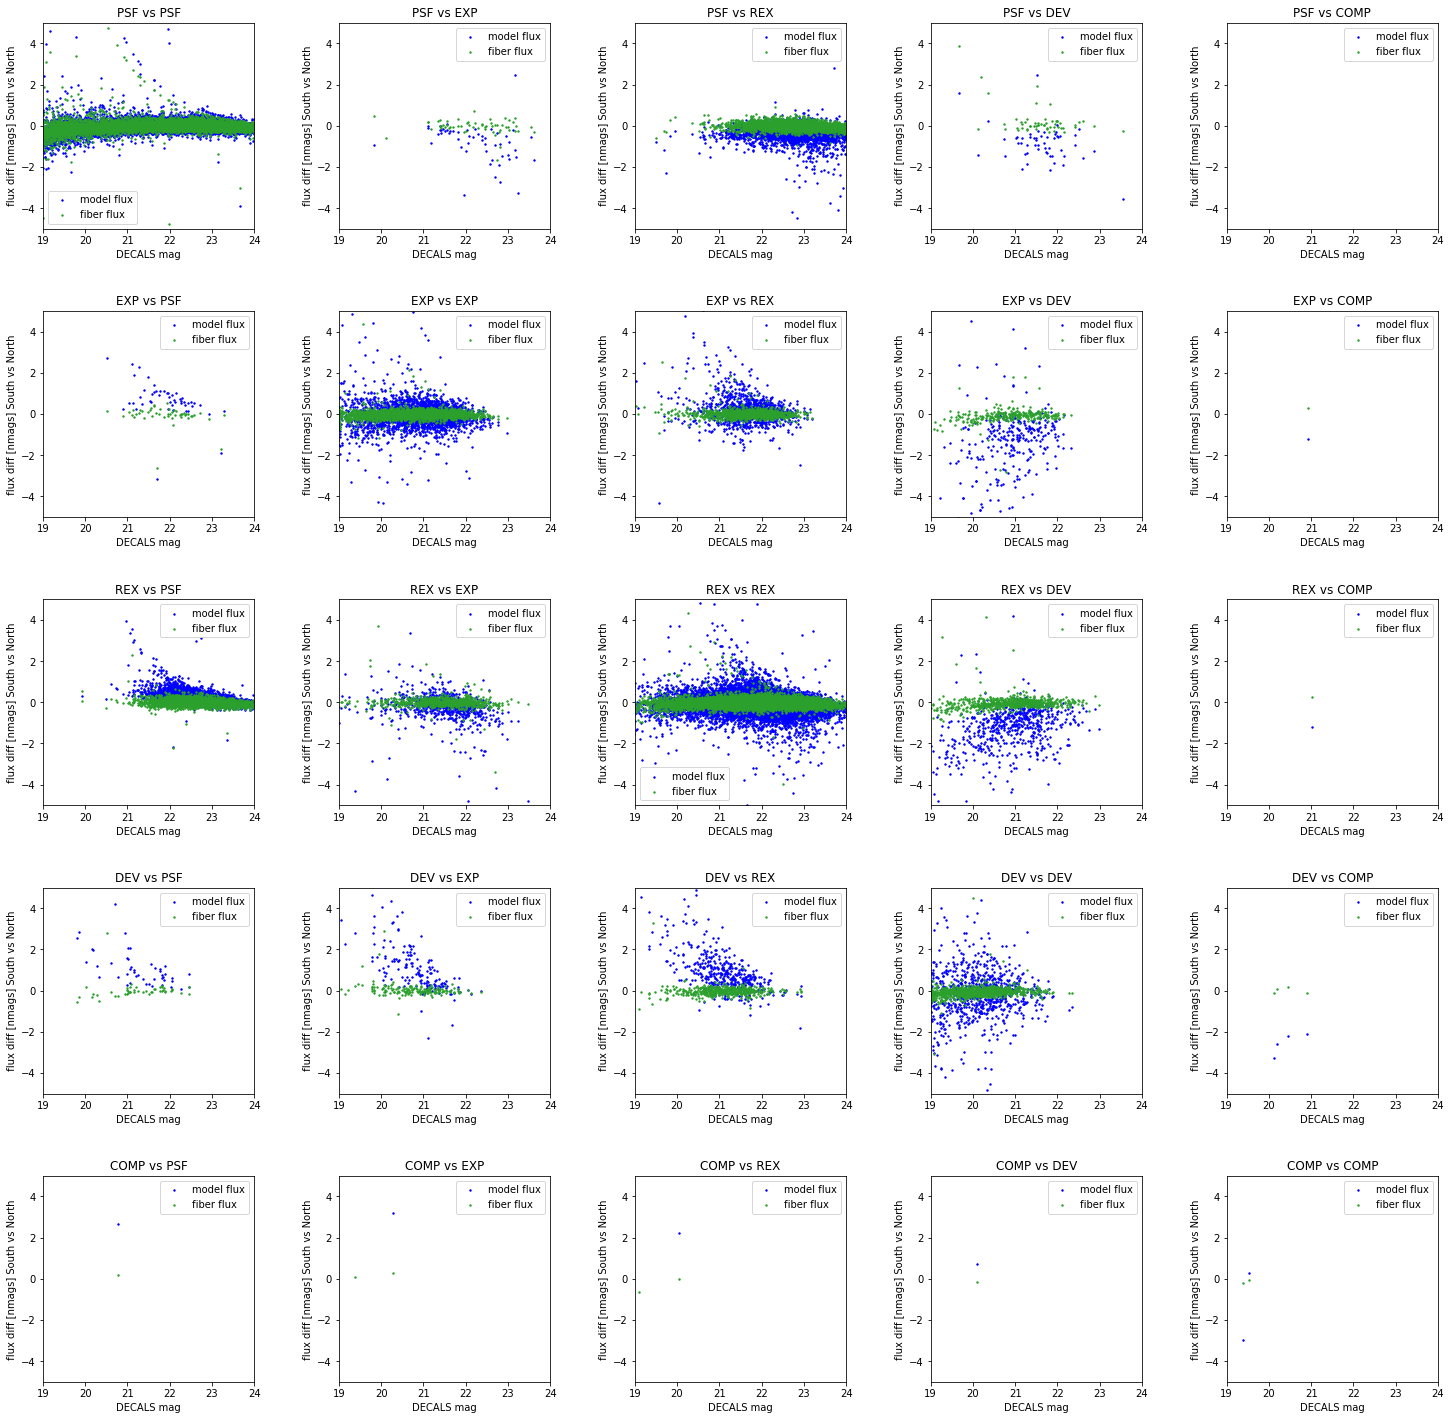

In [43]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_Z'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_Z'])
          
    decals_std_rflux = np.array(h5decals['FLUX_Z'])
    prime_std_rflux = np.array(h5prime['FLUX_Z'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1-zband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


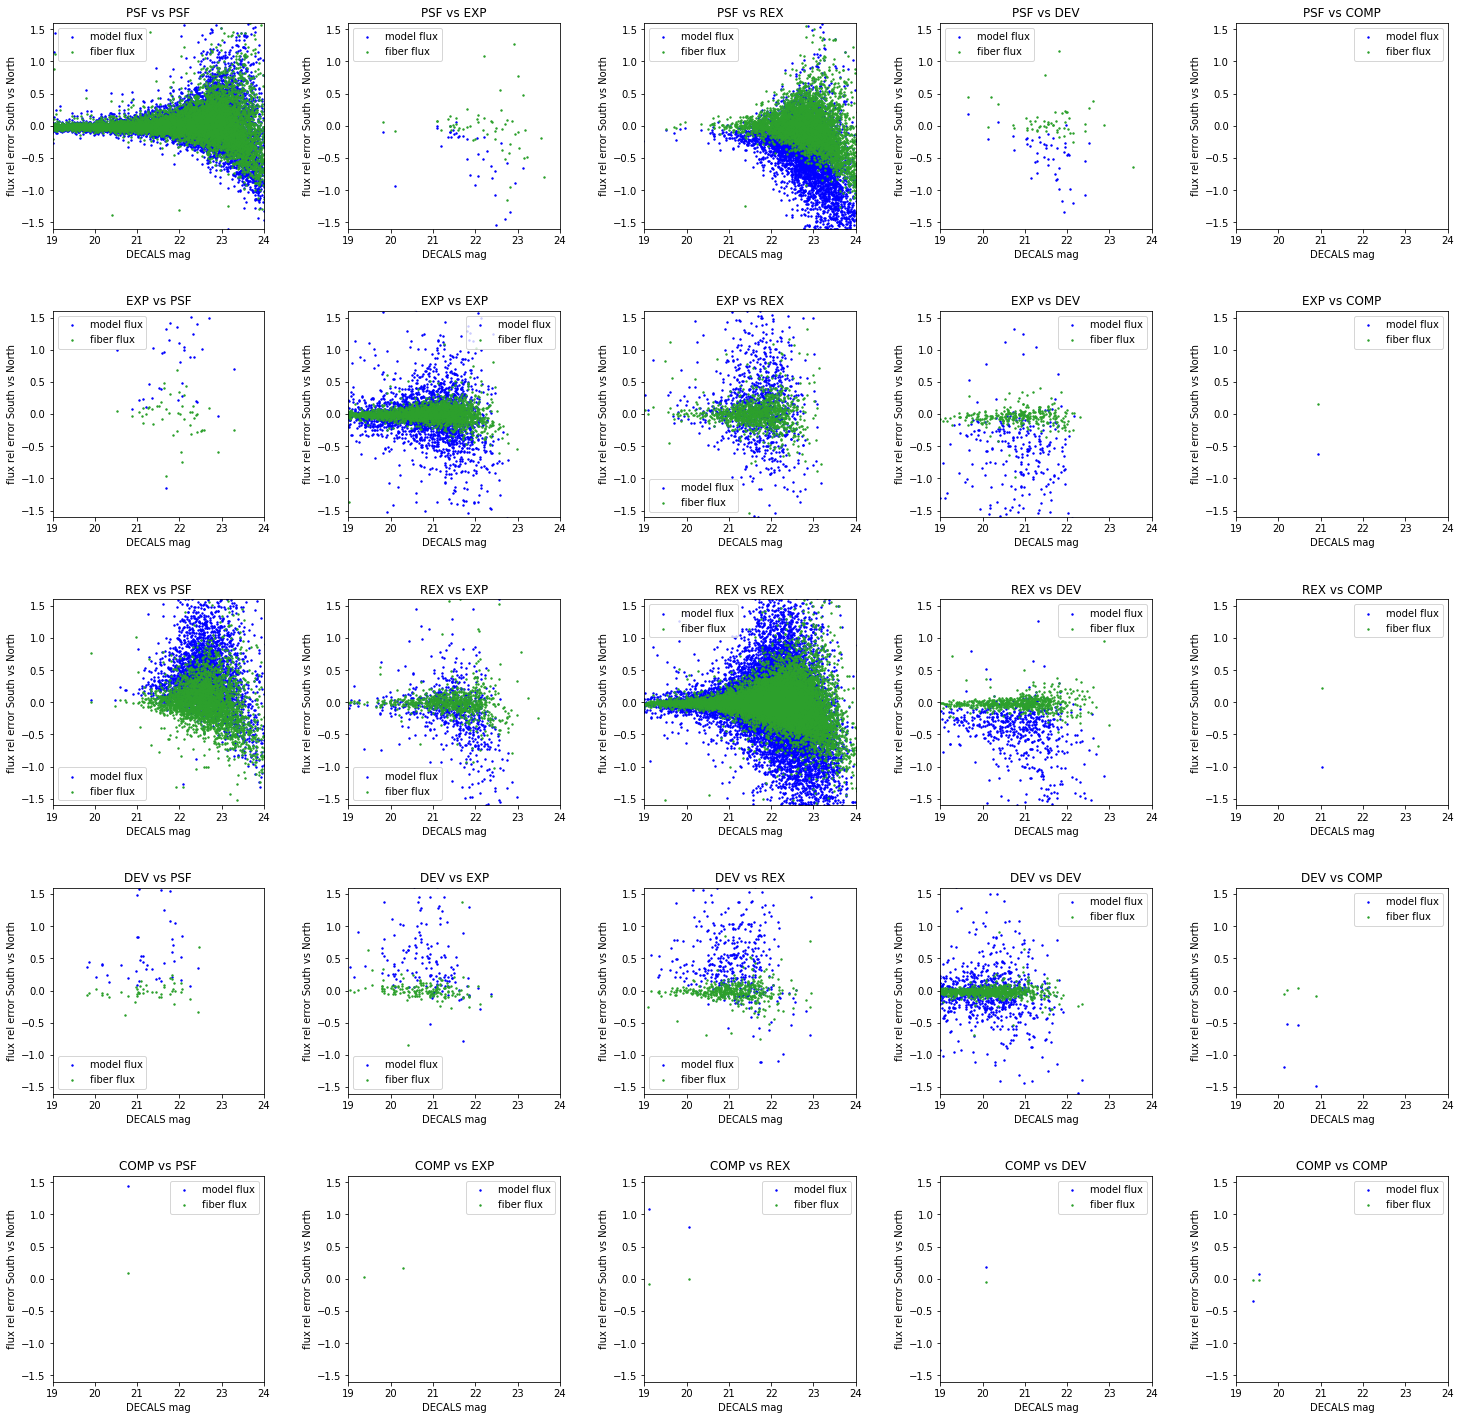

In [52]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_Z'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_Z'])
          
    decals_std_rflux = np.array(h5decals['FLUX_Z'])
    prime_std_rflux = np.array(h5prime['FLUX_Z'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'COMP']): 
            istype2 = istype1 & (h5prime['TYPE'].value.astype(str)== typ2)
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2-zband.png")
    plt.show()

#------------------------------------------------------------
#------------------------------------------------------------

### START DOWN BELOW FOR ALREADY MATCHED DATA

In [9]:
import gc
gc.collect() 

161

In [3]:
#no need to rerun this go below
f_decals = fits.open(
            os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep', 
                'sweep-130p030-140p035.fits')) 
    decals = f_decals[1].data 
    print('%i decals objects' % len(decals['ra']))
    
    # read in prime sweep
    f_prime = fits.open(
            os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/90prime-mosaic/sweep', 
                'sweep-130p030-140p035.fits'))
    prime = f_prime[1].data 
    print('%i prime objects' % len(prime['ra']))

1514729 decals objects
997127 prime objects


In [4]:
# no need to rerun this go below
    decals_radec_cut = (decals['ra'] > 136.) & (decals['ra'] < 137.) & (decals['dec'] > 32.)  & (decals['dec'] < 33.) 
    prime_radec_cut = (prime['ra'] > 136.) & (prime['ra'] < 137.) & (prime['dec'] > 32.)  & (prime['dec'] < 33.) 
    print('%i decals objects within cut' % np.sum(decals_radec_cut))
    print('%i prime objects within cut' % np.sum(prime_radec_cut)) 

61349 decals objects within cut
44273 prime objects within cut


(31.8, 33.2)

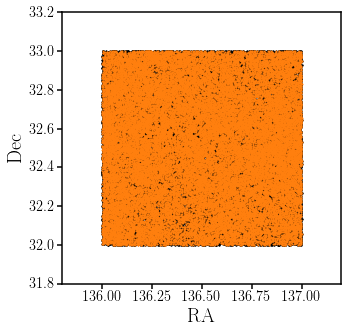

In [5]:
# no need to rerun this, go below
# validate the scatter plots 
    fig = plt.figure(figsize=(5,5))
    sub = fig.add_subplot(111)
    sub.scatter(decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], c='k', s=2) 
    sub.scatter(prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], c='C1', s=1) 
    sub.set_xlabel('RA', fontsize=20) 
    sub.set_xlim(135.8, 137.2) 
    sub.set_ylabel('Dec', fontsize=20) 
    sub.set_ylim(31.8, 33.2) 

In [7]:
# no need to rerun this go below
   fig.show()
   # fig.savefig('decals_prime_radec.png', bbox_inches='tight') 

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [3]:
# old case no need to reread original files 
def overlap(): 
    '''
    '''
    # read in decals sweep
    f_decals = fits.open(
            os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep', 
                'sweep-130p030-140p035.fits')) 
    decals = f_decals[1].data 
    print('%i decals objects' % len(decals['ra']))

    # read in prime sweep
    f_prime = fits.open(
            os.path.join('/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/90prime-mosaic/sweep', 
                'sweep-130p030-140p035.fits'))
    prime = f_prime[1].data 
    print('%i prime objects' % len(prime['ra']))

    decals_radec_cut = (decals['ra'] > 136.) & (decals['ra'] < 137.) & (decals['dec'] > 32.)  & (decals['dec'] < 33.) 
    prime_radec_cut = (prime['ra'] > 136.) & (prime['ra'] < 137.) & (prime['dec'] > 32.)  & (prime['dec'] < 33.) 
    print('%i decals objects within cut' % np.sum(decals_radec_cut))
    print('%i prime objects within cut' % np.sum(prime_radec_cut)) 

    # validate the scatter plots 
    fig = plt.figure(figsize=(5,5))
    sub = fig.add_subplot(111)
    sub.scatter(decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], c='k', s=2) 
    sub.scatter(prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], c='C1', s=1) 
    sub.set_xlabel('RA', fontsize=20) 
    sub.set_xlim(135.8, 137.2) 
    sub.set_ylabel('Dec', fontsize=20) 
    sub.set_ylim(31.8, 33.2) 
    fig.savefig('decals_prime_radec.png', bbox_inches='tight') 
    
    t0 = time.time() 
    # now lets spherematch 
    m_decals, m_prime, d_match = spherematch(
            decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], 
            prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], 
            0.0005, # match lenght roughly 1.5 arcsec
            maxmatch=1) 
    print('spehrematch takes', time.time() - t0) 
    print('%i out of %i decals objects have match' % (len(m_decals), np.sum(decals_radec_cut)))
    print('%i out of %i prime objects have match' % (len(m_prime), np.sum(prime_radec_cut)))
    np.save('decals_match.npy', m_decals)
    np.save('prime_match.npy', m_prime)

    fig = plt.figure()
    sub = fig.add_subplot(111)
    sub.scatter(decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], c='C0', s=4, label='DECALS') 
    sub.scatter(prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], c='C1', s=3, label='90prime') 
    sub.scatter(decals['ra'][decals_radec_cut][m_decals], decals['dec'][decals_radec_cut][m_decals], c='k', s=1, label='DECALS-PRIME') 
    sub.legend(loc='upper left', fontsize=20) 
    sub.set_xlabel('RA', fontsize=20) 
    sub.set_xlim(136.54, 136.56) 
    sub.set_ylabel('Dec', fontsize=20) 
    sub.set_ylim(32.54, 32.56) 
    fig.savefig('decals_prime_match_radec.png', bbox_inches='tight') 

    # save joint dataset
    f = h5py.File('decals_prime.radeccut.hdf5', 'w') 
    # save all the decals columns
    grp = f.create_group('decals') 
    for k in decals.names: 
        if len(decals[k]) == len(decals['ra']):  
            grp.create_dataset(k, data=decals[k][decals_radec_cut][m_decals]) 

    # save all the prime columns
    grp = f.create_group('prime') 
    for k in prime.names: 
        if len(prime[k]) == len(prime['ra']):  
            grp.create_dataset(k, data=prime[k][prime_radec_cut][m_prime]) 
    f.close() 
    return None 

In [8]:
   fig.savefig('decals_prime_radec.png', bbox_inches='tight') 

In [ ]:
# match no need to redo
    t0 = time.time() 
    # now lets spherematch 
    m_decals, m_prime, d_match = spherematch(
            decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], 
            prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], 
            0.0005, # match lenght roughly 1.5 arcsec
            maxmatch=1) 
    print('spehrematch takes', time.time() - t0) 
    print('%i out of %i decals objects have match' % (len(m_decals), np.sum(decals_radec_cut)))
    print('%i out of %i prime objects have match' % (len(m_prime), np.sum(prime_radec_cut)))
    np.save('decals_match.npy', m_decals)
    np.save('prime_match.npy', m_prime)


In [3]:
pathdir = '/global/project/projectdirs/desi/users/chahah/'
filename = pathdir + 'decals_match.npy'
m_decals = np.load(filename)
filename = pathdir + 'prime_match.npy'
m_prime = np.load(filename)

### START HERE FOR ALREADY MATCHED DATA

In [4]:
pathdir = '/global/project/projectdirs/desi/users/manera/'
f = h5py.File(pathdir+'decals_prime.radeccut.hdf5', 'r') 
decals = f['decals'] 
prime = f['prime'] 

In [5]:
def flux2mag(flux, band='g', method='log'):
    ''' given flux calculate SDSS asinh magnitude
    '''
    if method == 'asinh':
        if band == 'u': b = 1.4e-10
        elif band == 'g': b = 0.9e-10
        elif band == 'r': b = 1.2e-10
        elif band == 'i': b = 1.8e-10
        elif band == 'z': b = 7.4e-10
        else: raise ValueError

        return -2.5/np.log(10) * (np.arcsinh(1.e-9*flux/(2.*b)) + np.log(b))
    elif method == 'log':
        return 22.5 - 2.5 * np.log10(flux)

In [6]:
len(decals['TYPE'].value)

40468

### R-BAND

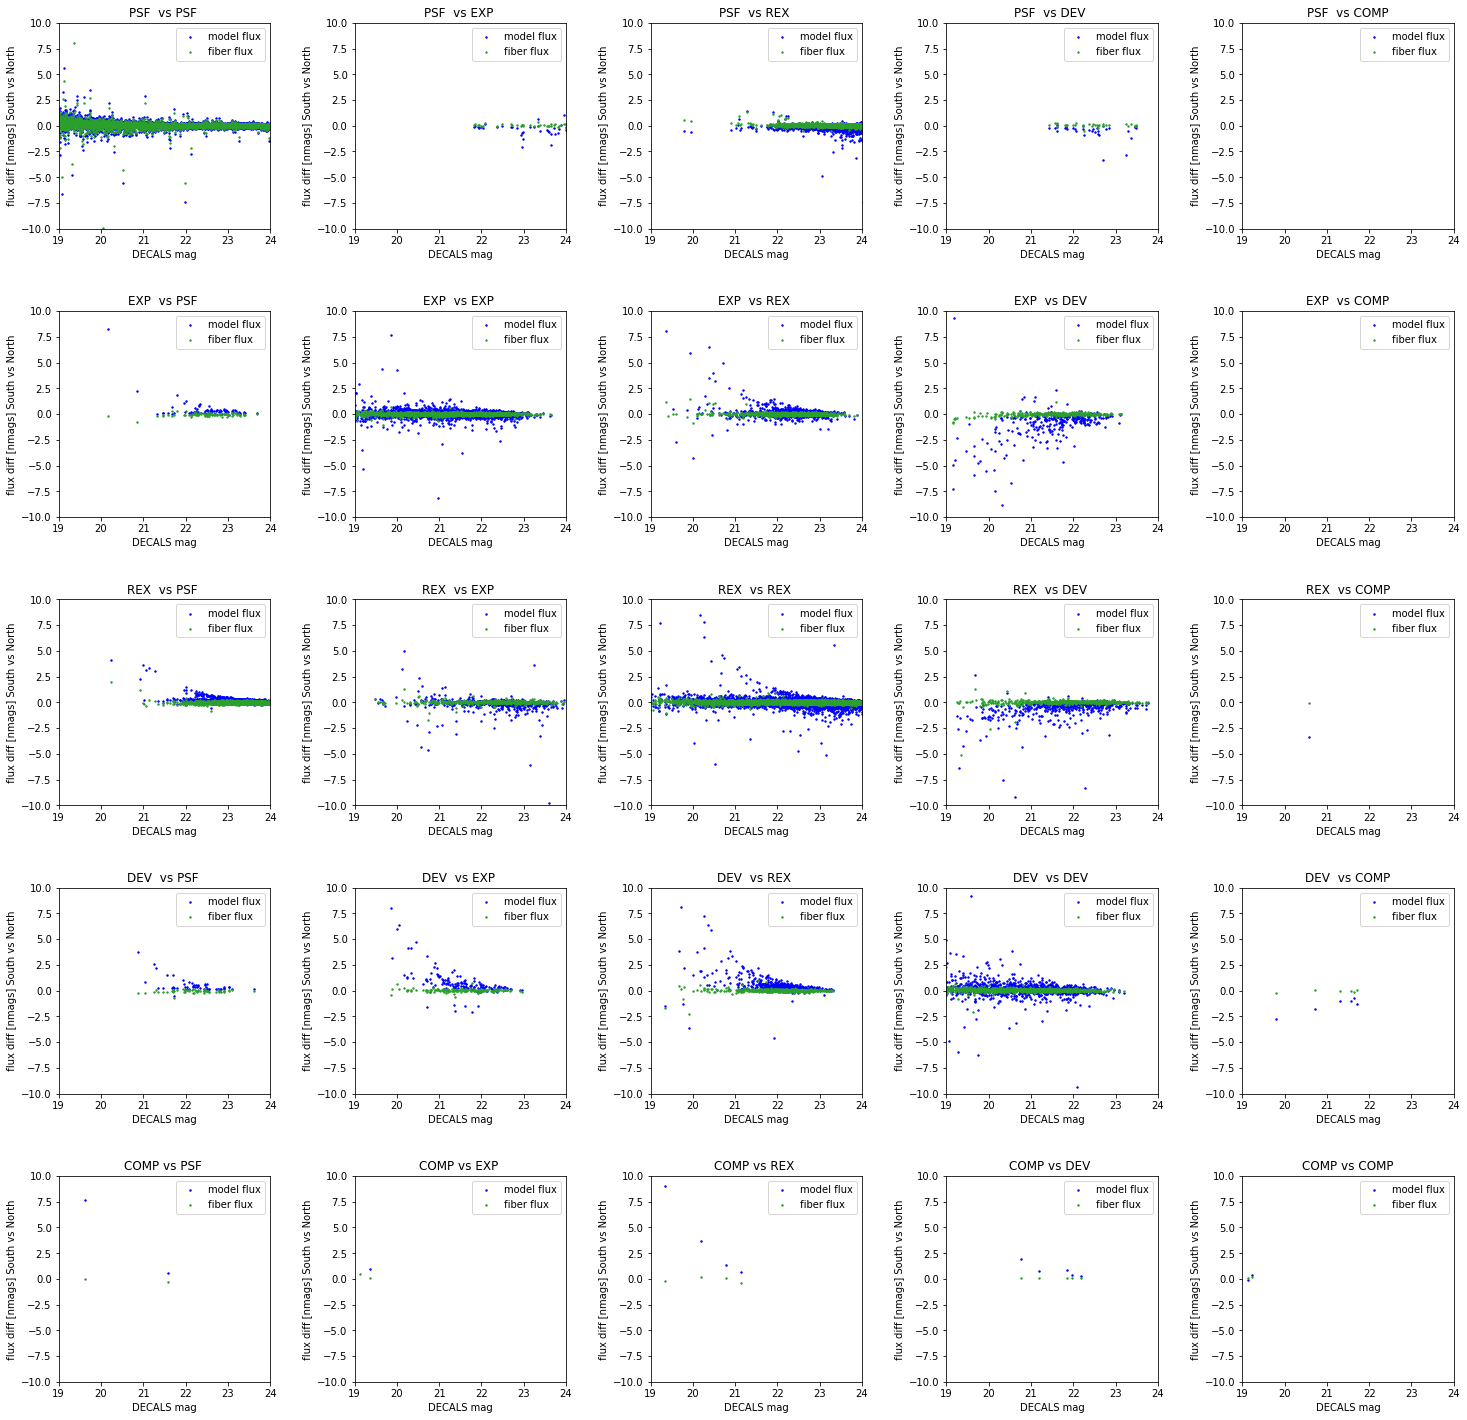

In [12]:
    decals_fib_rflux = np.array(decals['FIBERFLUX_R'])
    prime_fib_rflux = np.array(prime['FIBERFLUX_R'])
          
    decals_std_rflux = np.array(decals['FLUX_R'])
    prime_std_rflux = np.array(prime['FLUX_R'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype2], std_rflux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_rmag[istype2], fib_rflux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-10, 10) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparison-rband.png")
    plt.show()

### G-BAND

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in arcsinh
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in arcsinh


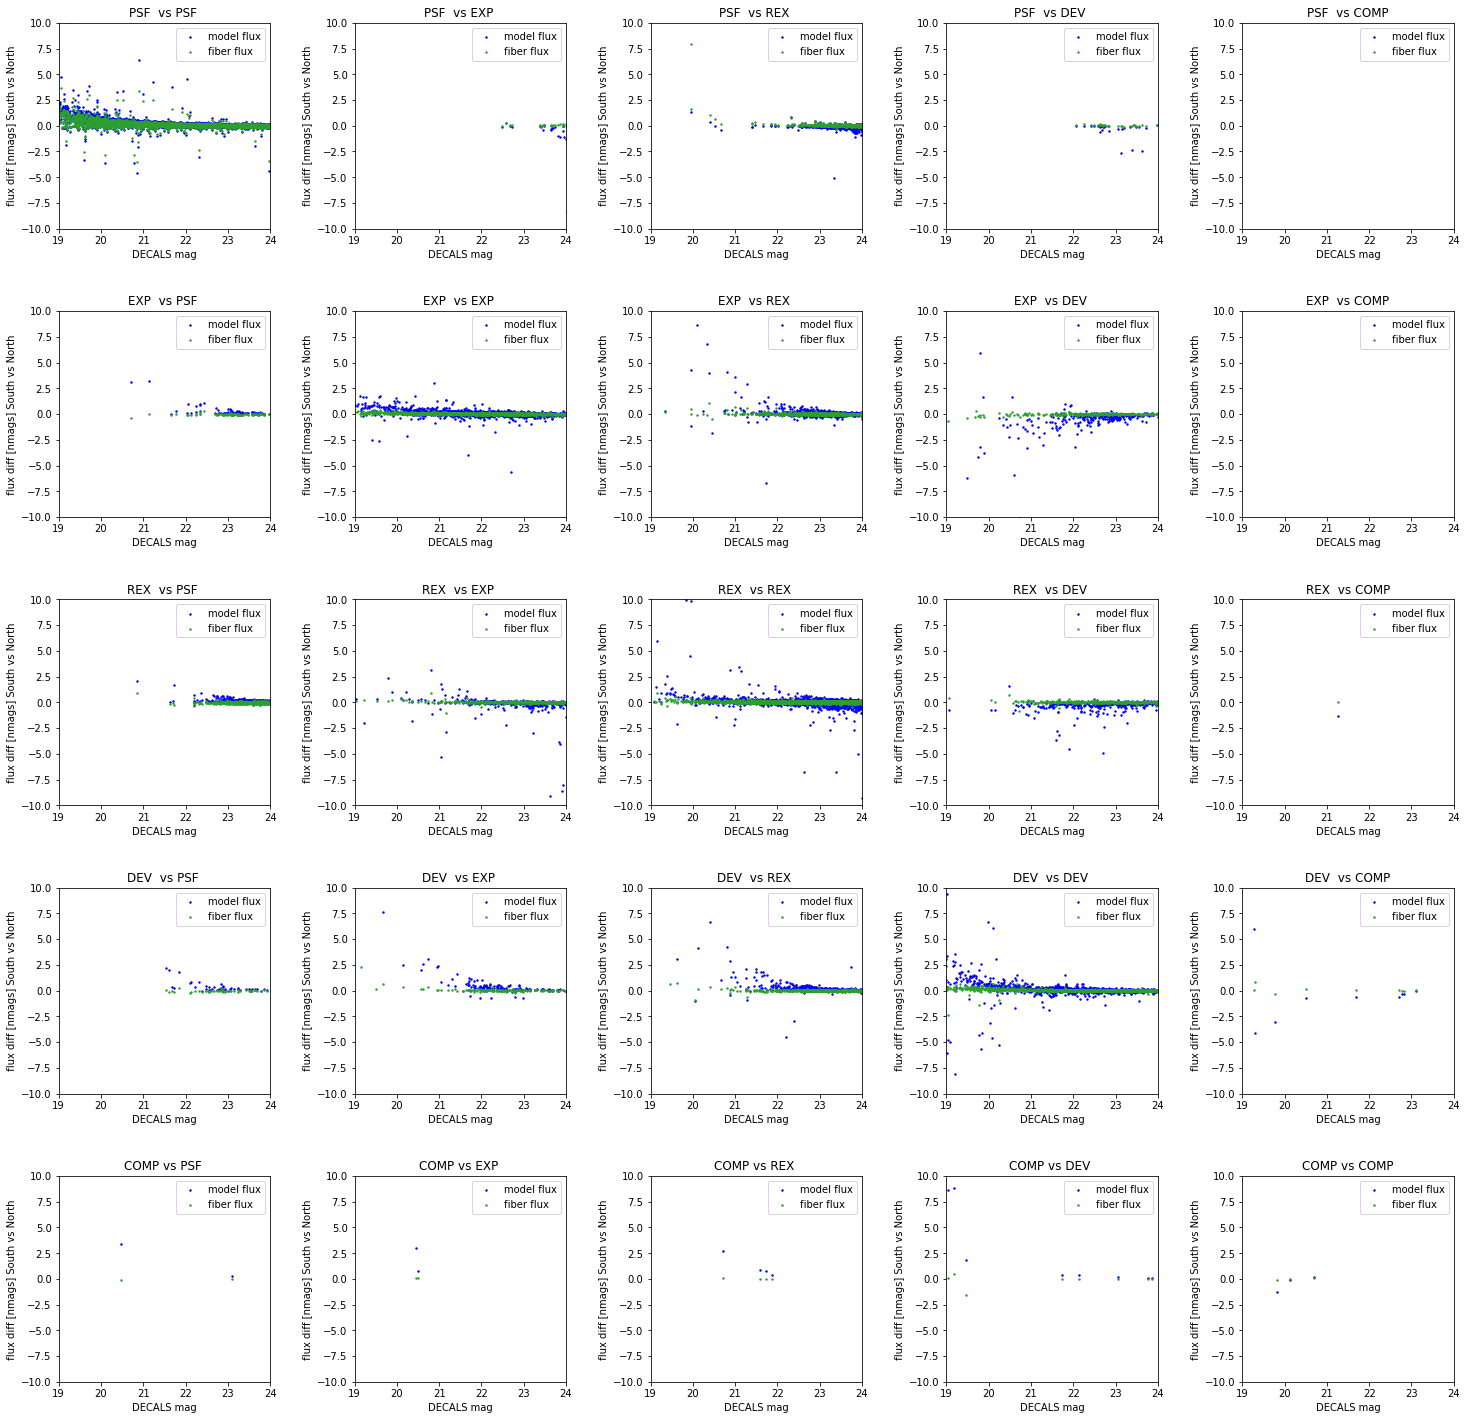

In [11]:
    decals_fib_flux = np.array(decals['FIBERFLUX_G'])
    prime_fib_flux = np.array(prime['FIBERFLUX_G'])
          
    decals_std_flux = np.array(decals['FLUX_G'])
    prime_std_flux = np.array(prime['FLUX_G'])
    
    fib_flux_diff = decals_fib_flux - prime_fib_flux
    std_flux_diff = decals_std_flux - prime_std_flux
    
    decals_std_mag = flux2mag(decals_std_flux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_mag[istype2], std_flux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_mag[istype2], fib_flux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-10, 10) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparison-gband.png")
    plt.show()

### Z-BAND

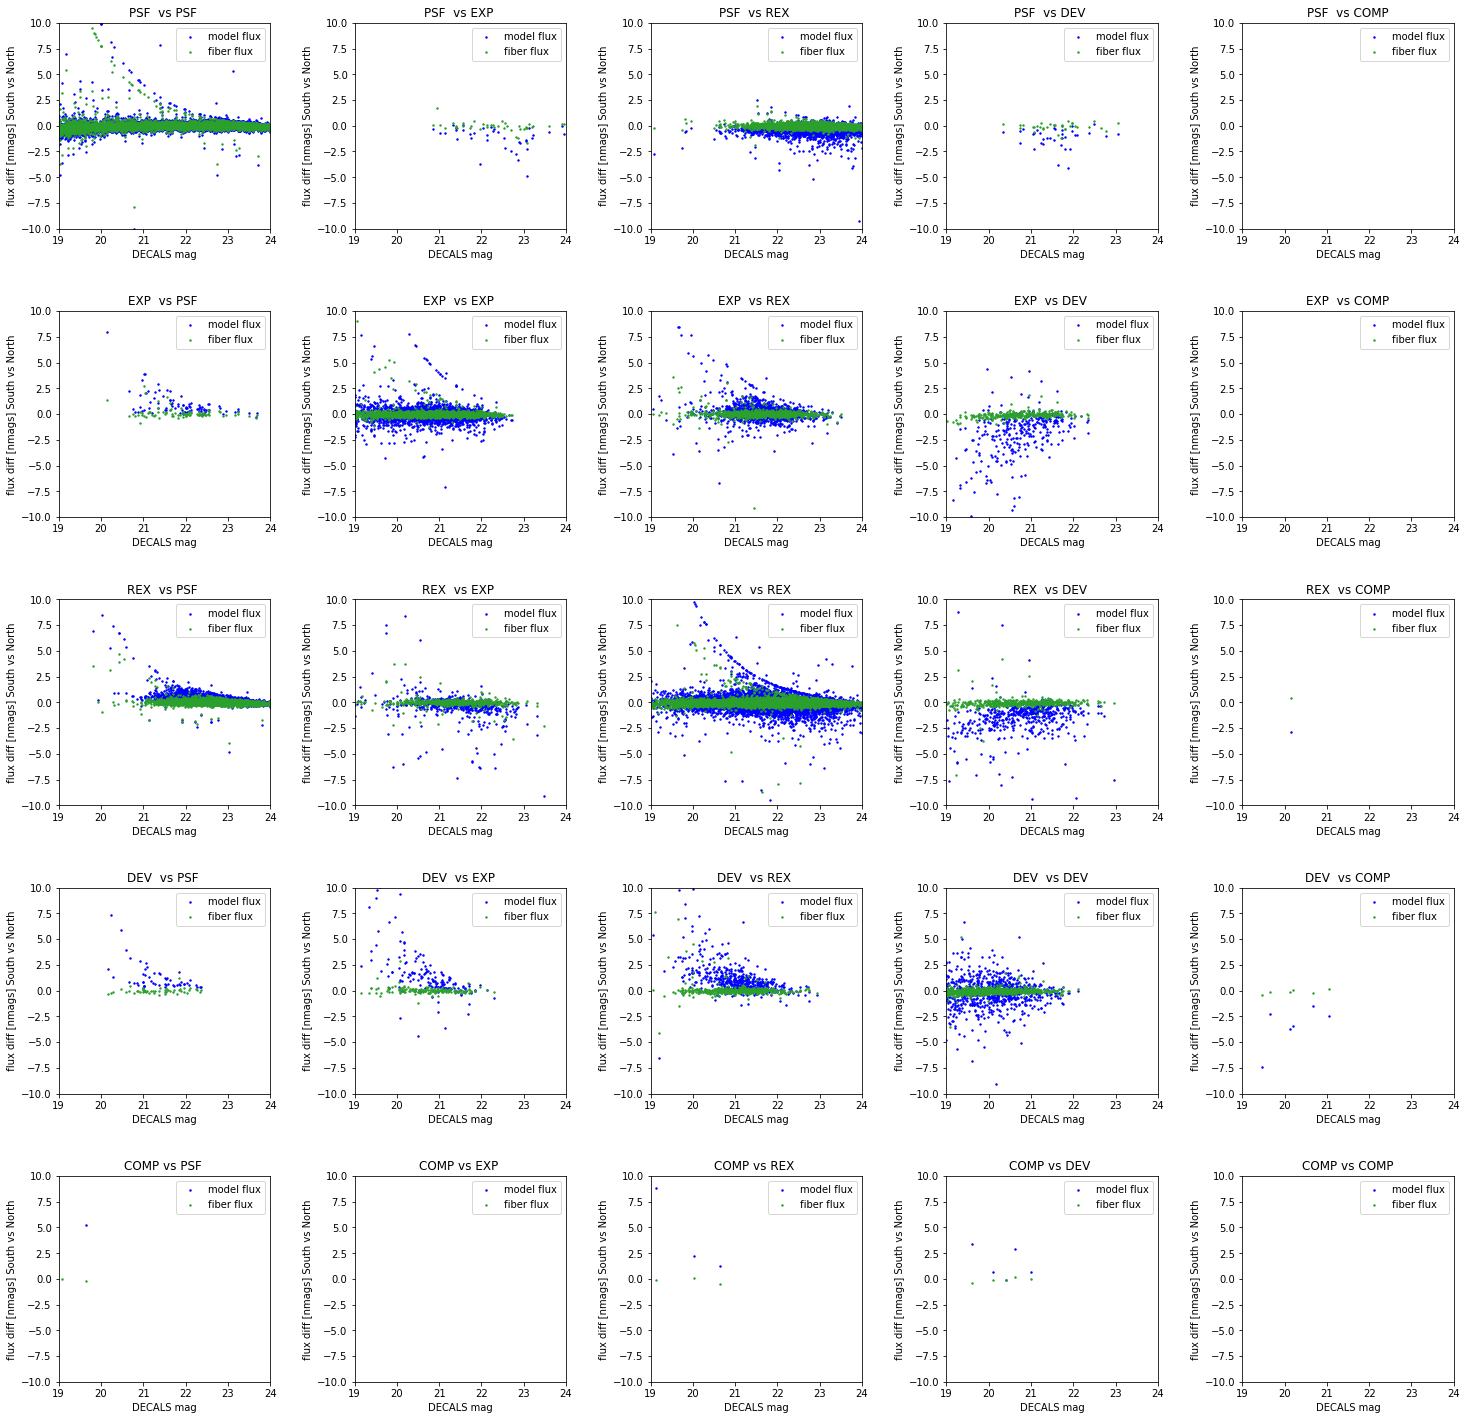

In [10]:
    decals_fib_flux = np.array(decals['FIBERFLUX_Z'])
    prime_fib_flux = np.array(prime['FIBERFLUX_Z'])
          
    decals_std_flux = np.array(decals['FLUX_Z'])
    prime_std_flux = np.array(prime['FLUX_Z'])
    
    fib_flux_diff = decals_fib_flux - prime_fib_flux
    std_flux_diff = decals_std_flux - prime_std_flux
    
    decals_std_mag = flux2mag(decals_std_flux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_mag[istype2], std_flux_diff[istype2], c='b', s=2)
            sub.scatter(decals_std_mag[istype2], fib_flux_diff[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-10, 10) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparison-zband.png")
    plt.show()

### OLD GOOD

In [ ]:
    fig = plt.figure(figsize=(24,4))
    for i, typ in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
        istype = (decals['TYPE'].value == typ)
        istype_wrong = istype & (prime['TYPE'].value != typ)
        sub = fig.add_subplot(1,5,i+1) 

        sub.scatter(decals_g_r[istype_wrong], prime_g_r[istype_wrong], c='C1', s=2) 
        sub.plot([-5, 5], [-5, 5], c='k', ls='--') 
        sub.set_title('DECALS TYPE == %s\n90prime TYPE != %s' % (typ, typ), fontsize=15)
        sub.set_xlabel('DECALS $g-r$', fontsize=20) 
        sub.set_ylabel('90prime $g-r$', fontsize=20) 
        sub.set_xlim(-5, 5) 
        sub.set_ylim(-5, 5) 
    fig.subplots_adjust(wspace=0.4)
    fig.savefig('decals_prime_wrongtype_gr_color_comp.png', bbox_inches='tight') 
    

In [26]:
#no need to redo this check
for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        print(istype1)

[ True  True  True ..., False  True  True]
[False False False ..., False False False]
[False False False ...,  True False False]
[False False False ..., False False False]
[False False False ..., False False False]


In [38]:
print(len(istype1))
print(len(istype2))

40468
40468


In [ ]:
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
            
            decals_fib_rmag = np.array(decals['FIBERFLUX_R'])
            prime_fib_rmag = np.array(prime['FIBERFLUX_R'])
          
            decals_rmag = np.array(decals['FLUX_R'])
            prime_rmag = np.array(prime['FLUX_R'])
           
            sub.scatter(decals_fib_rmag[istype2], prime_fib_rmag[istype2], c='C1', s=2)
            sub.scatter(decals_rmag[istype2], prime_rmag[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            #sub.set_title(mytitle)
            sub.set_xlim(0, 10) 
            sub.set_ylim(0, 10) 
            sub.set_xlabel('DECALS nmag')
            sub.set_ylabel('90PRIME nmag')
            sub.legend([mytitle])
            
    fig.subplots_adjust(wspace=0.4)
    plt.show()

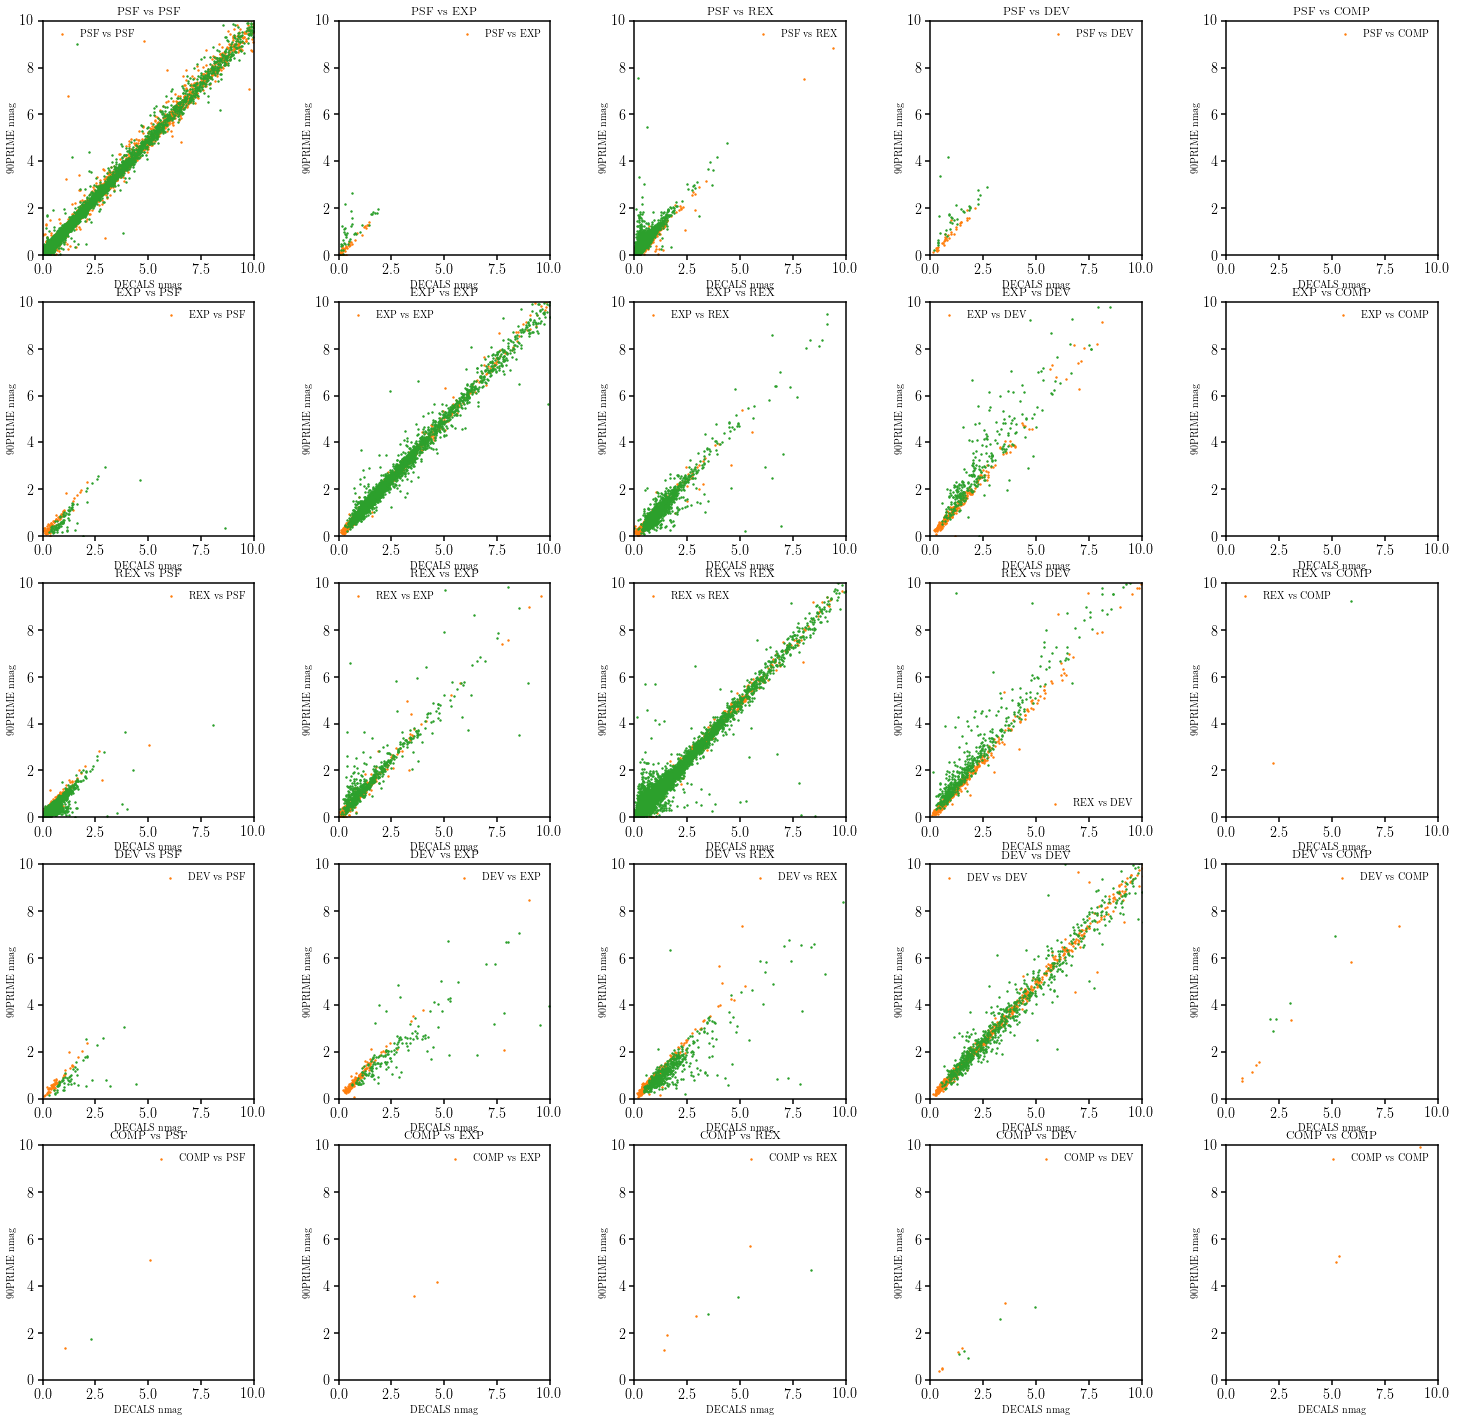

In [58]:
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
            
            decals_fib_rmag = np.array(decals['FIBERFLUX_R'])
            prime_fib_rmag = np.array(prime['FIBERFLUX_R'])
          
            decals_rmag = np.array(decals['FLUX_R'])
            prime_rmag = np.array(prime['FLUX_R'])
           
            sub.scatter(decals_fib_rmag[istype2], prime_fib_rmag[istype2], c='C1', s=2)
            sub.scatter(decals_rmag[istype2], prime_rmag[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            #sub.set_title(mytitle)
            sub.set_xlim(0, 10) 
            sub.set_ylim(0, 10) 
            sub.set_xlabel('DECALS nmag')
            sub.set_ylabel('90PRIME nmag')
            sub.legend([mytitle])
            
    fig.subplots_adjust(wspace=0.4)
    plt.show()

In [ ]:
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']):
        istype1 = (decals['TYPE'].value.astype(str) == typ1)
        for i2, typ2 in enumerate(['PSF ', 'EXP ', 'REX ', 'DEV ', 'COMP']): 
            istype2 = istype1 & (prime['TYPE'].value.astype(str) == typ2)
            
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
            
            decals_fib_rmag = np.array(decals['FIBERFLUX_R'])
            prime_fib_rmag = np.array(prime['FIBERFLUX_R'])
            diff_fib_rmag =  decals_fib_rmag - prime_fib_rmag 
        
            decals_rmag = np.array(decals['FLUX_R'])
            prime_rmag = np.array(prime['FLUX_R'])
            diff_rmag =  decals_rmag - prime_rmag    
        
            sub.scatter(decals_fib_rmag[istype2], prime_fib_rmag[istype2], c='C1', s=2)
            sub.scatter(decals_rmag[istype2], prime_rmag[istype2], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            #sub.set_title(mytitle)
            sub.set_xlim(0, 10) 
            sub.set_ylim(0, 10) 
            sub.set_xlabel('DECALS nmag')
            sub.set_ylabel('90PRIME nmag')
            sub.legend([mytitle])
            
    fig.subplots_adjust(wspace=0.4)
    plt.show()

### ------------ OLD --------------------

In [1]:
import numpy as np

In [ ]:
ftargets = '/global/cscratch1/sd/adamyers/dr8b-targets.fits'

In [6]:
dirDECAM='/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep/'
dirMOSAIC='/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/90prime-mosaic/sweep/'
ffile=dirMOSAIC+'sweep-130p030-140p035.fits'
ffile2=dirDECAM+'sweep-130p030-140p035.fits'
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from astropy.io import fits
%matplotlib inline

hdulist2 = fits.open(ffile2)
cols2 = hdulist2[1].columns
data2= hdulist2[1].data


hdulist1 = fits.open(ffile)
cols1 = hdulist1[1].columns
data1= hdulist1[1].data

Text(0.5,0,'DEC')

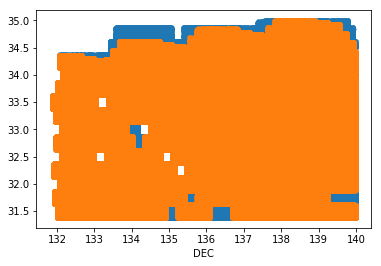

In [10]:
plt.plot(data1.field('RA'), data1.field('DEC'), '.')
plt.plot(data2.field('RA'), data2.field('DEC'), '.')
plt.xlabel('RA')
plt.xlabel('DEC')

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from astropy.io import fits
%matplotlib inline



In [6]:
sweepfiles = !ls /global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep/

In [7]:
sweepfiles

['sweep-000m005-010p000.fits',
 'sweep-000p000-010p005.fits',
 'sweep-010m005-020p000.fits',
 'sweep-010p000-020p005.fits',
 'sweep-020m005-030p000.fits',
 'sweep-020m010-030m005.fits',
 'sweep-020p000-030p005.fits',
 'sweep-030m005-040p000.fits',
 'sweep-030m010-040m005.fits',
 'sweep-030p000-040p005.fits',
 'sweep-040m005-050p000.fits',
 'sweep-040m010-050m005.fits',
 'sweep-040p000-050p005.fits',
 'sweep-130p030-140p035.fits',
 'sweep-130p035-140p040.fits',
 'sweep-140p030-150p035.fits',
 'sweep-170m005-180p000.fits',
 'sweep-170p000-180p005.fits',
 'sweep-180m005-190p000.fits',
 'sweep-180p000-190p005.fits',
 'sweep-230p000-240p005.fits',
 'sweep-230p005-240p010.fits',
 'sweep-230p010-240p015.fits',
 'sweep-240p000-250p005.fits',
 'sweep-240p005-250p010.fits',
 'sweep-240p010-250p015.fits']

In [27]:
myRA = 34.0
myDEC = -4.0
pathdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep/'
for sweepfile in sweepfiles:
    file2 = pathdir+sweepfile
    hdulist2 = fits.open(file2)
    cols2 = hdulist2[1].columns
    data2= hdulist2[1].data
    RAmin = np.min(data2.field('RA'))
    RAmax = np.max(data2.field('RA'))
    DECmin = np.min(data2.field('DEC'))
    DECmax = np.max(data2.field('DEC'))
    if( (myRA < float(RAmax)) & (myRA > float(RAmin)) & (myDEC < float(DECmax)) & (myDEC > float(DECmin))):
        print(sweepfile)
        print(myRA, myDEC)
        print(RAmin, RAmax)
        print(DECmin, DECmax)
    #plt.plot(data2.field('RA'), data2.field('DEC'), '.')
    #plt.xlabel('RA')
    #plt.xlabel('DEC')
    #plt.show()


sweep-030m005-040p000.fits
34.0 -4.0
30.0000031165 39.9999988104
-4.99999941717 -1.19199363493e-06


In [ ]:
dirDECAM='/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep/'

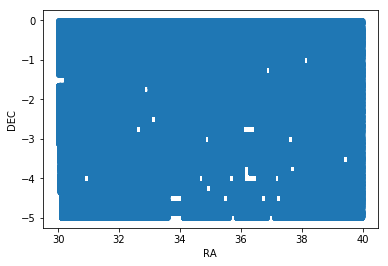

In [28]:

filename = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/sweep/sweep-030m005-040p000.fits'
hdulist2 = fits.open(filename)
cols2 = hdulist2[1].columns
data2= hdulist2[1].data
plt.plot(data2.field('RA'), data2.field('DEC'), '.')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

